# Evaluate likelihood ratio and posterior

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve

from units import *
from simulation import SubhaloSimulator
from inference.inference import Estimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

## Evaluate model on train and test data

In [4]:
x_train = np.load("../data/x_train.npy")
y_train = np.load("../data/y_train.npy")
theta_train = np.load("../data/theta_train.npy")

x_test = np.load("../data/x_test.npy")
y_test = np.load("../data/y_test.npy")
theta_test = np.load("../data/theta_test.npy")

In [5]:
x_train, y_train, theta_train = shuffle(x_train, y_train, theta_train)
x_train = x_train[:1000]
y_train = y_train[:1000]
theta_train = theta_train[:1000]

x_test, y_test, theta_test = shuffle(x_test, y_test, theta_test)
x_test = x_test[:1000]
y_test = y_test[:1000]
theta_test = theta_test[:1000]

print(np.sum(y_train) / 1000., np.sum(y_test) / 1000.)

0.497 0.528


## ROC curve

In [13]:
def make_roc_curves(name):
    re = Estimator()
    re.load("../models/" + name)
    
    llr_train, _ = re.evaluate_ratio(x=x_train, theta0=theta_train, test_all_combinations=False)
    s_train = s_from_r(np.exp(llr_train))
    
    llr_test, _ = re.evaluate_ratio(x=x_test, theta0=theta_test, test_all_combinations=False)
    s_test = s_from_r(np.exp(llr_test))
    
    fpr_train, tpr_train, _ = roc_curve(y_train, s_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, s_test)
    
    return fpr_train, tpr_train, fpr_test, tpr_test

In [14]:
fpr_train_alice, tpr_train_alice, fpr_test_alice, tpr_test_alice = make_roc_curves("alice")
fpr_train_carl, tpr_train_carl, fpr_test_carl, tpr_test_carl = make_roc_curves("carl")

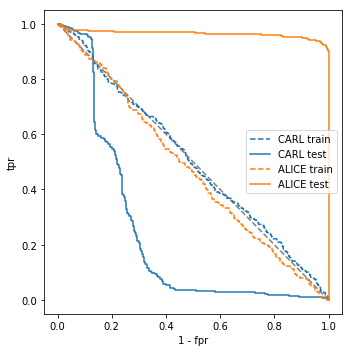

In [18]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
plt.plot(1. - fpr_train_carl, tpr_train_carl, c="C0", ls="--", label="CARL train")
plt.plot(1. - fpr_test_carl, tpr_test_carl, c="C0", ls="-", label="CARL test")
plt.plot(1. - fpr_train_alice, tpr_train_alice, c="C1", ls="--", label="ALICE train")
plt.plot(1. - fpr_test_alice, tpr_test_alice, c="C1", ls="-", label="ALICE test")

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.show()


## Evaluate on grid

In [27]:
grid_res = 21

alpha_test = np.linspace(1000., 4000., grid_res)
beta_test = np.linspace(-1.6, -3.4, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [28]:
re = Estimator()
re.load("../models/alice")

nllr, _ = re.evaluate_ratio(x=x_test[:10], theta0=theta_grid)
nllr = -2. * nllr

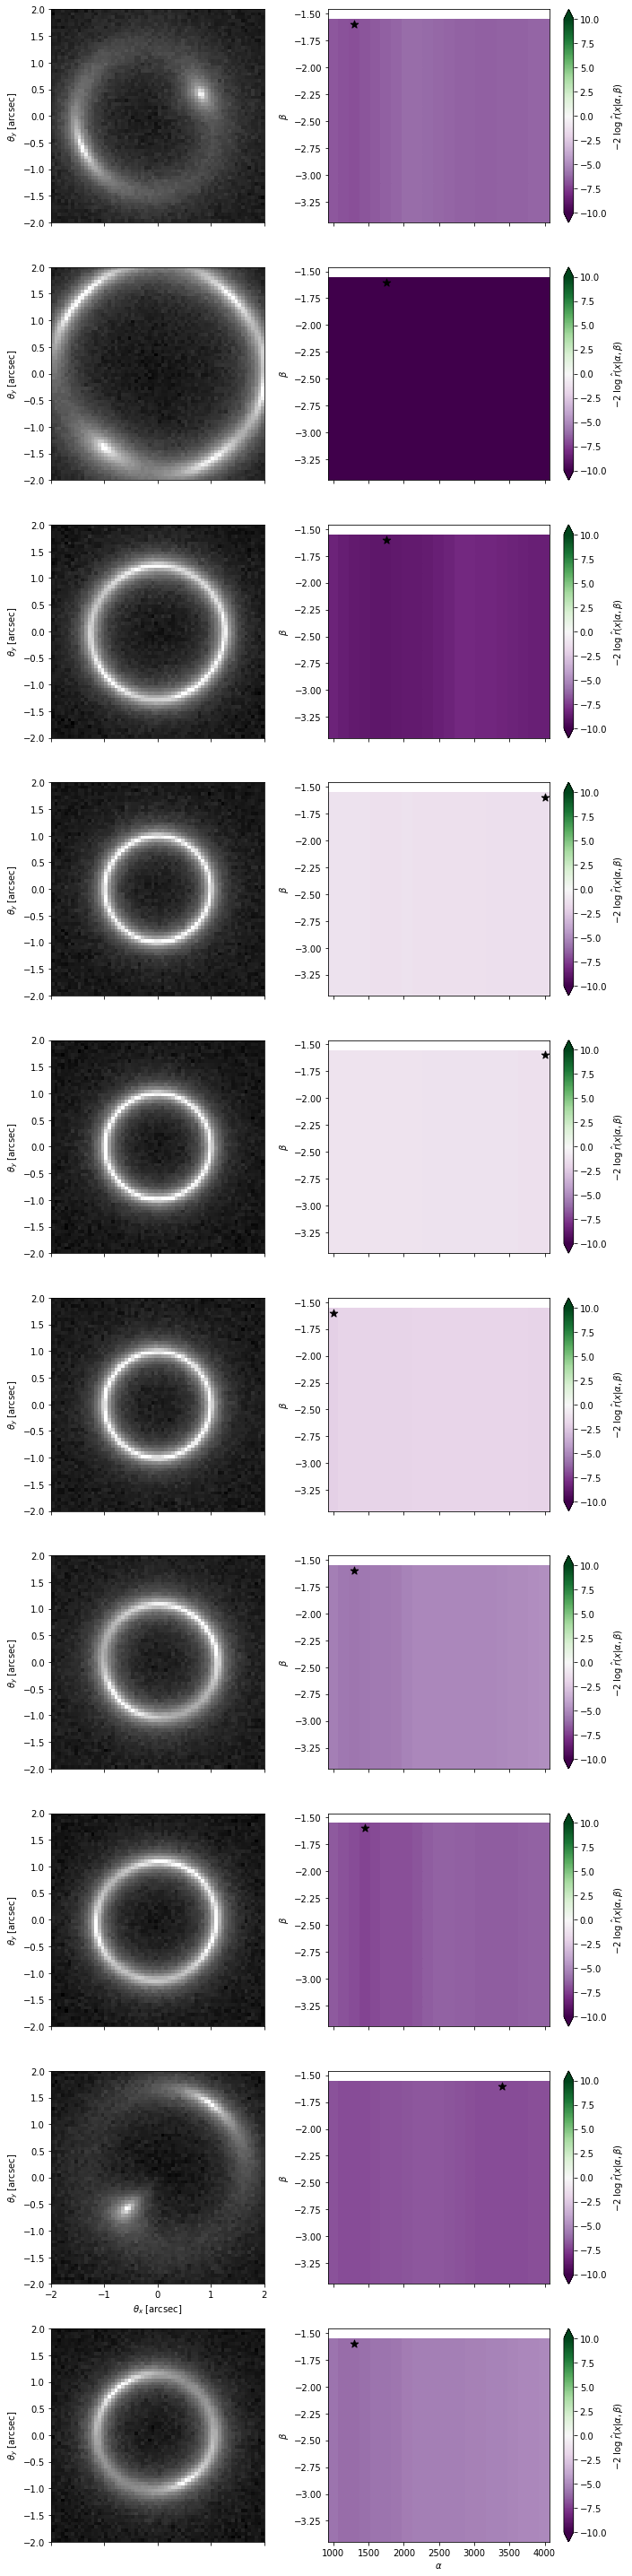

In [29]:
fig = plt.figure(figsize=(10, 4 * 10))

for i in [9,0,1,2,3,4,5,6,7,8]:
    
    # Plot image
    if i == 9:
        ax_left = plt.subplot(10, 2, i*2+1)
        ax = ax_left
    else:
        ax = plt.subplot(10, 2, i*2+1, sharex=ax_left)
    
    plt.imshow(
        np.log10(x_test[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    #sc = plt.scatter(
    #    pos_subs[i][:,0],
    #    pos_subs[i][:,1],
    #    s=50.,
    #    c=np.log10(m_subs[i][:]),
    #    cmap="plasma",
    #    vmin=2.,
    #    vmax=5.,
    #)
    #cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    if i == 8:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    #cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
    
    # Plot estimated likelihood ratio for this image
    if i == 9:
        ax_right = plt.subplot(10, 2, i*2+2)
        ax = ax_right
    else:
        ax = plt.subplot(10, 2, i*2+2, sharex=ax_right)
        
    nllr_ = nllr[:, i]

    best_fit = theta_grid[np.argmin(nllr_)]
    cmin, cmax = -10., 10.  # np.min(nllr_), np.max(nllr_)

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        nllr_.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

    if i == 9:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$')

plt.tight_layout()
plt.savefig("alice_predictions.pdf")